# Clip USDM

a. stein 4.19.2022

Soooo, the USDM file is really large (572 GB it looks) ... and I know a lot of that is empty masked data, so let's see if I can trim some of that down and reduce the file size.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


In [2]:
usdm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/usdm'
conus_path = f'{usdm_path}/CONUS'
global_path = f'{usdm_path}/Global'

In [3]:
start_time = '20000104'
end_time = '20220412'
start_date = pd.to_datetime(start_time).strftime('%Y%m%d')
end_date = pd.to_datetime(end_time).strftime('%Y%m%d')
dates = pd.date_range(start_date, end_date, freq='7D')

In [4]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
wa_gdf = states_gdf[(states_gdf.NAME=='Washington')]

In [5]:
usdm_global_all = xr.open_dataset(f'{global_path}/USDM_{start_time}_{end_time}.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/usdm/Global/USDM_20000104_20220412.nc'

Can I just use these states outlines to clip to CONUS?

fig, ax = plt.subplots(figsize=(20,10))

usdm_global_all['USDM'].isel(date=0).plot(ax=ax, cmap='viridis')
states_gdf.plot(ax=ax, edgecolor='k', color='none', alpha=0.5)

That's fairly good ... maybe adding some padding would be safe, or can revisit in future. Not sure why it has those weird stripes.

Is the impression that it has grids everywhere actually accurate?

Text(0.5, 0.98, 'USDM coordinate spread')

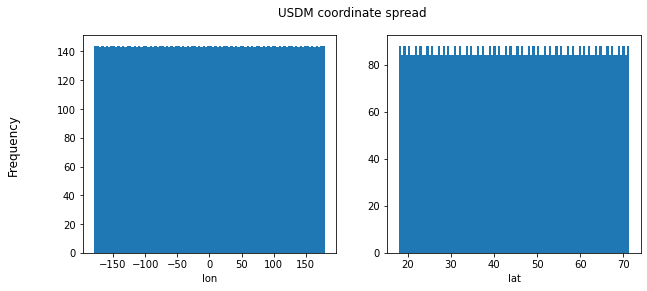

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].hist(usdm_global_all['lon'].values, bins=100)
ax[0].set_xlabel('lon')

ax[1].hist(usdm_global_all['lat'].values, bins=100);
ax[1].set_xlabel('lat')

fig.supylabel('Frequency')
fig.suptitle('USDM coordinate spread')

Yep. 

In [ ]:
usdm_20000104 = xr.open_dataset(f'{global_path}/USDM_{start_time}.nc')
usdm_20000104 = usdm_20000104.rename({'__xarray_dataarray_variable__':'USDM'})
usdm_20000104_da = usdm_20000104['USDM'].rio.write_crs('EPSG:4326')
usdm_20000104_da

<xarray.DataArray 'USDM' (band: 1, y: 2142, x: 14358)>
[30754836 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.8 179.8
  * y            (y) float64 71.4 71.37 71.35 71.32 ... 17.95 17.92 17.9 17.87
    spatial_ref  int64 0
Attributes:
    grid_mapping:  spatial_ref

In [ ]:
usdm_20000104_da_states = wrangle.clip_xarray(usdm_20000104_da, states_gdf)
usdm_20000104_da_states

<xarray.DataArray 'USDM' (band: 1, y: 2138, x: 14357)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 71.35 71.32 71.3 71.27 ... 18.0 17.97 17.95 17.92
  * x            (x) float64 -179.1 -179.1 -179.1 -179.1 ... 179.7 179.7 179.8
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    grid_mapping:  spatial_ref

Text(0.5, 0.98, 'USDM 20000104 States Clipped coordinate spread')

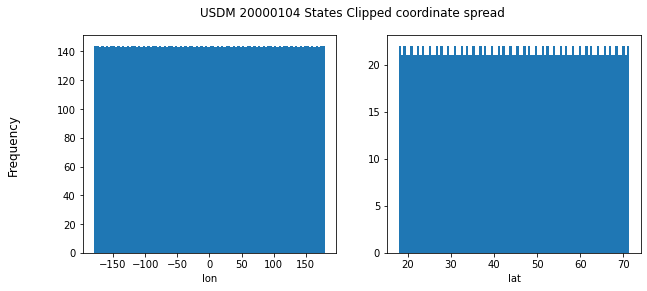

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].hist(usdm_20000104_da_states['x'].values, bins=100)
ax[0].set_xlabel('lon')

ax[1].hist(usdm_20000104_da_states['y'].values, bins=100);
ax[1].set_xlabel('lat')

fig.supylabel('Frequency')
fig.suptitle(f'USDM {start_time} States Clipped coordinate spread')

ah, right, AK still peaking over is going to throw a wrench in the clipping ... let's make it actually just CONUS

In [ ]:
conus_gdf = states_gdf[(states_gdf['NAME'] != 'Alaska')&(states_gdf['NAME'] != 'Hawaii')&(states_gdf['NAME'] != 'Puerto Rico')]

In [ ]:
usdm_20000104_da_conus = wrangle.clip_xarray(usdm_20000104_da, conus_gdf)
usdm_20000104_da_conus

<xarray.DataArray 'USDM' (band: 1, y: 994, x: 2312)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 49.37 49.35 49.32 49.3 ... 24.62 24.6 24.57 24.55
  * x            (x) float64 -124.7 -124.7 -124.7 ... -67.01 -66.98 -66.96
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    grid_mapping:  spatial_ref

In [ ]:
print(f'Original All Time: {usdm_global_all.nbytes/1E9} GB')
print(f'Original: {usdm_global_all.isel(date=0).nbytes/1E9} GB')
print(f'States: {usdm_20000104_da_states.nbytes/1E9} GB')
print(f'CONUS: {usdm_20000104_da_conus.nbytes/1E9} GB')

Original All Time: 1144.572169296 GB
Original: 0.984338176 GB
States: 0.245562128 GB
CONUS: 0.018385024 GB


Oh, alright, clipping to states actually does a pretty good job too. That's ridiculous how much was being taken up by no-data

Now how much is lost by this conversion?

In [ ]:
global_cells = len(usdm_20000104_da.values.ravel())
states_cells = len(usdm_20000104_da_states.values.ravel())
conus_cells = len(usdm_20000104_da_conus.values.ravel())

global_data_cells = len(np.where(np.isnan(usdm_20000104_da.values.ravel()) == False)[0])
states_data_cells = len(np.where(np.isnan(usdm_20000104_da_states.values.ravel()) == False)[0])
conus_data_cells = len(np.where(np.isnan(usdm_20000104_da_conus.values.ravel()) == False)[0])

print(f'Global: {global_cells} cells, {usdm_20000104_da.nbytes/1E6:.2f} MB')
print(f'Global: {global_data_cells} cells contain data, ({100*(global_data_cells/global_cells):.2f}%)')
print()
print(f'State-clipped: {states_cells} cells, {usdm_20000104_da_states.nbytes/1E6:.2f} MB')
print(f'State-clipped: {states_data_cells} cells contain data, ({100*(states_data_cells/states_cells):.2f}%)')
print(f'Data Lost by State-clipping : {(1 - (states_data_cells/global_data_cells))*100:.4f}%')
print()
print(f'CONUS-clipped: {conus_cells} cells, {usdm_20000104_da_conus.nbytes/1E6:.2f} MB')
print(f'CONUS-clipped: {conus_data_cells} cells contain data, ({100*(conus_data_cells/conus_cells):.2f}%)')
print(f'Data Lost by CONUS-clipping : {(1 - (conus_data_cells/global_data_cells))*100:.4f}%')

Global: 30754836 cells, 246.04 MB
Global: 1760710 cells contain data, (5.72%)

State-clipped: 30695266 cells, 245.56 MB
State-clipped: 1760152 cells contain data, (5.73%)
Data Lost by State-clipping : 0.0317%

CONUS-clipped: 2298128 cells, 18.39 MB
CONUS-clipped: 1309410 cells contain data, (56.98%)
Data Lost by CONUS-clipping : 25.6317%


Alright, so there is some loss, padding the states geometry would be helpful then to not loose any valuable data. If I can get the "Data Lost by State-Clipping to 0%" ... then I will know I successfully captured all the data that I want for CONUS as well.

In [6]:
states_net = states_gdf.copy()
states_net = states_net.to_crs('EPSG:3857')
conus_net = states_net[(states_gdf['NAME'] != 'Alaska')&(states_gdf['NAME'] != 'Hawaii')&(states_gdf['NAME'] != 'Puerto Rico')]

In [7]:
import shapely

In [8]:
# this results in a loss of 0.00278 %, which seems to be the best I can get
buffer_distance = 4.2E4 # m

states_buffer = states_net.buffer(distance=buffer_distance)
states_buffer_geometry = shapely.ops.unary_union([poly for poly in states_buffer.geometry])

conus_buffer = conus_net.buffer(distance=buffer_distance)
conus_buffer_geometry = shapely.ops.unary_union([poly for poly in conus_buffer.geometry])

In [9]:
states_buffer_gs = gpd.GeoSeries(states_buffer_geometry, crs=states_net.crs)
states_buffer_gs = states_buffer_gs.to_crs('EPSG:4326')

conus_buffer_gs = gpd.GeoSeries(conus_buffer_geometry, crs=conus_net.crs)
conus_buffer_gs = conus_buffer_gs.to_crs('EPSG:4326')

In [10]:
usdm_20000104_da_states_inc = wrangle.clip_xarray(usdm_20000104_da, states_buffer_gs)
usdm_20000104_da_conus_inc = wrangle.clip_xarray(usdm_20000104_da, conus_buffer_gs)

NameError: name 'usdm_20000104_da' is not defined

In [ ]:
global_cells = len(usdm_20000104_da.values.ravel())
states_cells = len(usdm_20000104_da_states_inc.values.ravel())
conus_cells = len(usdm_20000104_da_conus_inc.values.ravel())

global_data_cells = len(np.where(np.isnan(usdm_20000104_da.values.ravel()) == False)[0])
states_data_cells = len(np.where(np.isnan(usdm_20000104_da_states_inc.values.ravel()) == False)[0])
conus_data_cells = len(np.where(np.isnan(usdm_20000104_da_conus_inc.values.ravel()) == False)[0])

print(f'Global: {global_cells} cells, {usdm_20000104_da.nbytes/1E6:.2f} MB')
print(f'Global: {global_data_cells} cells contain data, ({100*(global_data_cells/global_cells):.2f}%)')
print()
print(f'State-clipped: {states_cells} cells, {usdm_20000104_da_states_inc.nbytes/1E6:.2f} MB')
print(f'State-clipped: {states_data_cells} cells contain data, ({100*(states_data_cells/states_cells):.2f}%)')
print(f'Data Lost by State-clipping : {(1 - (states_data_cells/global_data_cells))*100}%')
print()
print(f'CONUS-clipped: {conus_cells} cells, {usdm_20000104_da_conus_inc.nbytes/1E6:.2f} MB')
print(f'CONUS-clipped: {conus_data_cells} cells contain data, ({100*(conus_data_cells/conus_cells):.2f}%)')
print(f'Data Lost by CONUS-clipping : {(1 - (conus_data_cells/global_data_cells))*100:.4f}%')

Global: 30754836 cells, 246.04 MB
Global: 1760710 cells contain data, (5.72%)

State-clipped: 30754836 cells, 246.04 MB
State-clipped: 1760661 cells contain data, (5.72%)
Data Lost by State-clipping : 0.0027829682344049367%

CONUS-clipped: 2384156 cells, 19.07 MB
CONUS-clipped: 1309573 cells contain data, (54.93%)
Data Lost by CONUS-clipping : 25.6224%


Looks like that's as good as I'll get. If there's a way to simply create a geometry from the cells that have data that'd probably be best, but I have no clue how to do that and documentation for geometric operations on xarray datasets is horrible.

Let's loop through and clip to CONUS for the rest of them.

In [11]:
for date in tqdm(dates):
    date_str = date.strftime('%Y%m%d')
    global_ds = xr.open_dataset(f'{global_path}/USDM_{date_str}.nc')
    global_ds = global_ds.rename({'__xarray_dataarray_variable__':'USDM'})
    global_da = global_ds['USDM'].rio.write_crs('EPSG:4326')
    
    conus_da = wrangle.clip_xarray(global_da, conus_buffer_gs)

    try:
        os.remove(f'{conus_path}/USDM_{date_str}.nc')
    except:
        pass

    conus_da.attrs = global_ds.attrs
    conus_da.to_netcdf(f'{conus_path}/USDM_{date_str}.nc')

    global_ds = None
    global_da = None
    conus_da = None

  0%|          | 0/1163 [00:00<?, ?it/s]

Delightful. Let's concat them.

In [12]:
usdm_conus_files = [f"{conus_path}/USDM_{date.strftime('%Y%m%d')}.nc" for date in dates]
usdm_conus_all = xr.open_mfdataset(usdm_conus_files, combine='nested', concat_dim='band', join='left')

In [13]:
print(f'CONUS All : {usdm_conus_all.nbytes/1E9:.2f} GB')
usdm_conus_all

CONUS All : 22.18 GB


<xarray.Dataset>
Dimensions:      (y: 1018, x: 2342, band: 1163)
Coordinates:
  * y            (y) float64 49.62 49.6 49.57 49.55 ... 24.27 24.25 24.22 24.2
  * x            (x) float64 -125.1 -125.1 -125.1 ... -66.63 -66.61 -66.58
  * band         (band) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    spatial_ref  (band) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    USDM         (band, y, x) float64 dask.array<chunksize=(1, 1018, 2342), meta=np.ndarray>

Now to clean it up a little ...

In [14]:
usdm_conus_all = usdm_conus_all.rename({'y':'lat', 'x':'lon', 'band':'date'})
usdm_conus_all['date'] = dates

In [15]:
usdm_conus_all

<xarray.Dataset>
Dimensions:      (lat: 1018, lon: 2342, date: 1163)
Coordinates:
  * lat          (lat) float64 49.62 49.6 49.57 49.55 ... 24.27 24.25 24.22 24.2
  * lon          (lon) float64 -125.1 -125.1 -125.1 ... -66.63 -66.61 -66.58
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    spatial_ref  (date) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    USDM         (date, lat, lon) float64 dask.array<chunksize=(1, 1018, 2342), meta=np.ndarray>

In [16]:
spatial_ref_attrs = usdm_conus_all['spatial_ref'].attrs
del usdm_conus_all['spatial_ref']
usdm_conus_all

<xarray.Dataset>
Dimensions:  (lat: 1018, lon: 2342, date: 1163)
Coordinates:
  * lat      (lat) float64 49.62 49.6 49.57 49.55 ... 24.27 24.25 24.22 24.2
  * lon      (lon) float64 -125.1 -125.1 -125.1 -125.0 ... -66.63 -66.61 -66.58
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 dask.array<chunksize=(1, 1018, 2342), meta=np.ndarray>

In [17]:
usdm_conus_all['USDM'].attrs = spatial_ref_attrs
usdm_conus_all['USDM']

<xarray.DataArray 'USDM' (date: 1163, lat: 1018, lon: 2342)>
dask.array<concatenate, shape=(1163, 1018, 2342), dtype=float64, chunksize=(1, 1018, 2342), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 49.62 49.6 49.57 49.55 ... 24.27 24.25 24.22 24.2
  * lon      (lon) float64 -125.1 -125.1 -125.1 -125.0 ... -66.63 -66.61 -66.58
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -125.12090760646159 0.025 0.0 49.6355481069...

In [18]:
usdm_conus_all.attrs = {
    'compilation':'a. stein, 4/22/2022',
    'description':'weekly gridded United States Drought Monitor (USDM) from 1/4/2000 to 4/18/2022 for CONUS',
    'source': 'https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-tiff/wgs84-tiff/',
    'crs': 'EPSG:4326',
    'join': 'lat, lon taken from 2000-01-04 file',
    'clipping': 'original data was clipped to CONUS using http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json by reprojecting in ESPG:3857 with a 42 km buffer, then projecting back into EPSG:4326, resulting in a data loss of 0.00278% and reducing the net size of this file from 1.14 TB to 82.6 GiB'
}
usdm_conus_all

<xarray.Dataset>
Dimensions:  (lat: 1018, lon: 2342, date: 1163)
Coordinates:
  * lat      (lat) float64 49.62 49.6 49.57 49.55 ... 24.27 24.25 24.22 24.2
  * lon      (lon) float64 -125.1 -125.1 -125.1 -125.0 ... -66.63 -66.61 -66.58
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 dask.array<chunksize=(1, 1018, 2342), meta=np.ndarray>
Attributes:
    compilation:  a. stein, 4/22/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:4326
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to CONUS using http://eric.clst.o...

In [19]:
usdm_conus_all['date'].attrs = {'notes':'release date for USDM map according to file naming convention, release time not documented here'}
usdm_conus_all['date']

<xarray.DataArray 'date' (date: 1163)>
array(['2000-01-04T00:00:00.000000000', '2000-01-11T00:00:00.000000000',
       '2000-01-18T00:00:00.000000000', ..., '2022-03-29T00:00:00.000000000',
       '2022-04-05T00:00:00.000000000', '2022-04-12T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Attributes:
    notes:    release date for USDM map according to file naming convention, ...

In [20]:
usdm_conus_all

<xarray.Dataset>
Dimensions:  (lat: 1018, lon: 2342, date: 1163)
Coordinates:
  * lat      (lat) float64 49.62 49.6 49.57 49.55 ... 24.27 24.25 24.22 24.2
  * lon      (lon) float64 -125.1 -125.1 -125.1 -125.0 ... -66.63 -66.61 -66.58
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 dask.array<chunksize=(1, 1018, 2342), meta=np.ndarray>
Attributes:
    compilation:  a. stein, 4/22/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:4326
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to CONUS using http://eric.clst.o...

In [21]:
usdm_conus_all.load()

<xarray.Dataset>
Dimensions:  (lat: 1018, lon: 2342, date: 1163)
Coordinates:
  * lat      (lat) float64 49.62 49.6 49.57 49.55 ... 24.27 24.25 24.22 24.2
  * lon      (lon) float64 -125.1 -125.1 -125.1 -125.0 ... -66.63 -66.61 -66.58
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    compilation:  a. stein, 4/22/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:4326
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to CONUS using http://eric.clst.o...

In [22]:
try:
    os.remove(f'{usdm_path}/USDM_CONUS_20000104_20220412.nc')
except:
    pass
usdm_conus_all.to_netcdf(f'{usdm_path}/USDM_CONUS_20000104_20220412.nc')

In [23]:
usdm_conus_all.close()

Wonderful. Let's now also do that for just Washington real quick so that I have a nice test case to work with. I'll be clipping from the original files again to avoid errors generated by clipping a clipping.

Now for Washington I do not want to provide a buffer cause then that might bleed into other states, so I'll just have to use the geometry that I have.

In [24]:
wa_path = f'{usdm_path}/WA'

wa_gdf = states_gdf[states_gdf['NAME']=='Washington']
wa_gdf

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
47,0400000US53,53,Washington,,66455.521,"MULTIPOLYGON (((-122.51954 48.28831, -122.5227..."


In [25]:
for date in tqdm(dates):
    date_str = date.strftime('%Y%m%d')
    global_ds = xr.open_dataset(f'{global_path}/USDM_{date_str}.nc')
    global_ds = global_ds.rename({'__xarray_dataarray_variable__':'USDM'})
    global_da = global_ds['USDM'].rio.write_crs('EPSG:4326')
    
    wa_da = wrangle.clip_xarray(global_da, wa_gdf)

    try:
        os.remove(f'{wa_path}/USDM_{date_str}.nc')
    except:
        pass

    wa_da.attrs = global_ds.attrs
    wa_da.to_netcdf(f'{wa_path}/USDM_{date_str}.nc')

    global_ds = None
    global_da = None
    wa_da = None

  0%|          | 0/1163 [00:00<?, ?it/s]

In [26]:
usdm_wa_files = [f"{wa_path}/USDM_{date.strftime('%Y%m%d')}.nc" for date in dates]
usdm_wa_all = xr.open_mfdataset(usdm_wa_files, combine='nested', concat_dim='band', join='left')

In [27]:
print(f'USDM WA: {usdm_wa_all.nbytes/1E9:.2f} GB')
usdm_wa_all

USDM WA: 0.41 GB


<xarray.Dataset>
Dimensions:      (y: 139, x: 314, band: 1163)
Coordinates:
  * y            (y) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * x            (x) float64 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * band         (band) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    spatial_ref  (band) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    USDM         (band, y, x) float64 dask.array<chunksize=(1, 139, 314), meta=np.ndarray>

Now that's a nice and easy file size. Let's wrap up the other cleaning we need for this file.

In [28]:
usdm_wa_all = usdm_wa_all.rename({'y':'lat', 'x':'lon', 'band':'date'})
usdm_wa_all['date'] = dates

In [29]:
usdm_wa_all

<xarray.Dataset>
Dimensions:      (lat: 139, lon: 314, date: 1163)
Coordinates:
  * lat          (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon          (lon) float64 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    spatial_ref  (date) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    USDM         (date, lat, lon) float64 dask.array<chunksize=(1, 139, 314), meta=np.ndarray>

In [30]:
spatial_ref_attrs = usdm_wa_all['spatial_ref'].attrs
del usdm_wa_all['spatial_ref']
usdm_wa_all

<xarray.Dataset>
Dimensions:  (lat: 139, lon: 314, date: 1163)
Coordinates:
  * lat      (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 dask.array<chunksize=(1, 139, 314), meta=np.ndarray>

In [31]:
usdm_wa_all['USDM'].attrs = spatial_ref_attrs
usdm_wa_all['USDM']

<xarray.DataArray 'USDM' (date: 1163, lat: 139, lon: 314)>
dask.array<concatenate, shape=(1163, 139, 314), dtype=float64, chunksize=(1, 139, 314), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -124.74590760646159 0.024999999999999963 0....

In [32]:
usdm_wa_all.attrs = {
    'compilation':'a. stein, 4/20/2022',
    'description':'weekly gridded United States Drought Monitor (USDM) from 1/4/2000 to 4/18/2022 for Washington State',
    'source': 'https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-tiff/wgs84-tiff/',
    'crs': 'EPSG:4326',
    'join': 'lat, lon taken from 2000-01-04 file',
    'clipping': 'original data was clipped to Washington using http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
}
usdm_wa_all

<xarray.Dataset>
Dimensions:  (lat: 139, lon: 314, date: 1163)
Coordinates:
  * lat      (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 dask.array<chunksize=(1, 139, 314), meta=np.ndarray>
Attributes:
    compilation:  a. stein, 4/20/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:4326
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to Washington using http://eric.c...

In [33]:
usdm_wa_all['date'].attrs = {'notes':'release date for USDM map according to file naming convention, release time not documented here'}
usdm_wa_all['date']

<xarray.DataArray 'date' (date: 1163)>
array(['2000-01-04T00:00:00.000000000', '2000-01-11T00:00:00.000000000',
       '2000-01-18T00:00:00.000000000', ..., '2022-03-29T00:00:00.000000000',
       '2022-04-05T00:00:00.000000000', '2022-04-12T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Attributes:
    notes:    release date for USDM map according to file naming convention, ...

In [34]:
usdm_wa_all

<xarray.Dataset>
Dimensions:  (lat: 139, lon: 314, date: 1163)
Coordinates:
  * lat      (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 dask.array<chunksize=(1, 139, 314), meta=np.ndarray>
Attributes:
    compilation:  a. stein, 4/20/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:4326
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to Washington using http://eric.c...

In [35]:
usdm_wa_all.load()

<xarray.Dataset>
Dimensions:  (lat: 139, lon: 314, date: 1163)
Coordinates:
  * lat      (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    compilation:  a. stein, 4/20/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:4326
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to Washington using http://eric.c...

In [36]:
try:
    os.remove(f'{usdm_path}/USDM_WA_20000104_20220412.nc')
except:
    pass
usdm_wa_all.to_netcdf(f'{usdm_path}/USDM_WA_20000104_20220412.nc')

In [37]:
usdm_wa_all.close()

Let's double check the data looks right ...

In [ ]:
usdm_wa_all = xr.open_dataset(f'{usdm_path}/USDM_WA_20000104_20220412.nc')

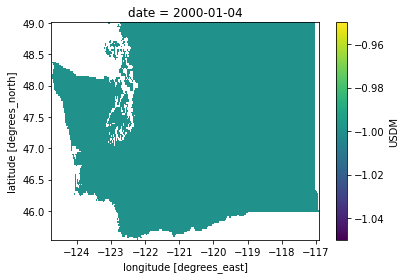

In [ ]:
usdm_wa_all['USDM'].isel(date=0).plot()

## The issue below has been resolved by changing `open_mfdataset` to using `join='left'`. I'll leave it for reference, but am putting it in markdown.
## Issue summary: y-coordinate mismatch led to more y-coordinates being stored than really existed, creating areas of blank data where new coordinates were inserted without more data

Why are there lines ...

test = xr.open_dataset(f'{wa_path}/USDM_20000104.nc')
test['USDM'].plot()
ax.set_title('20000104')

Strange ... did this happen with the CONUS data?

usdm_conus_all['USDM'].isel(date=0).plot()

ARRGGGG.

So the clipping itself went fine ... which means something had to have gone wrong in the aggregation process. But I have no clue why it would.

Let's start at the call of the aggregation file.

usdm_wa_all_re = xr.open_mfdataset(usdm_wa_files, combine='nested', concat_dim='band')

usdm_wa_all_re['USDM'].isel(band=0).plot()

Well I guess there is my problem ... but why?

Let's see if I can prove the arrays are different and make sure it's not just something weird with the plotting interface.

truth_vals = test['USDM'].values
corrupt_vals = usdm_wa_all_re['USDM'].isel(band=0).values

np.where(truth_vals == corrupt_vals)

size(truth_vals)

size(corrupt_vals)

Wtf

usdm_wa_all_re['USDM'].isel(band=0)

test['USDM'].isel(band=0)

how did more y values manage to get in there??

I wonder ... was there a change in USDM resolution over time that resulted in stretching this out? cause the clipping shape is the same ... and if something changed the resolution then that would explain gaps appearing when everything is put on the same coordinate system ...

fig, ax = plt.subplots(2,2, figsize=(12,5))
ax[0,0].plot(test['x'].to_dataframe().diff(), marker='.', linestyle='')
ax[0,0].set_ylabel('Change in x per measurement')
ax[1,0].plot(test['y'].to_dataframe().diff(), marker='.', linestyle='')
ax[1,0].set_ylabel('Change in y per measurement')

ax[0,1].plot(usdm_wa_all_re['x'].to_dataframe().diff(), marker='.', linestyle='')
ax[1,1].plot(usdm_wa_all_re['y'].to_dataframe().diff(), marker='.', linestyle='')
plt.tight_layout()

Okay yeah, there is a different y resolution it seems (from there being different difference bands) ... let's see if I can find where this change occurs ...

y_sizes = {}

for date in tqdm(dates):
    date_str = date.strftime('%Y%m%d')
    with xr.open_dataset(f'{wa_path}/USDM_{date_str}.nc') as file:
        y_sizes[date] = len(file['y'])

fig, ax = plt.subplots()

ax.plot(list(y_sizes.keys()), list(y_sizes.values()))

.... well that's confusing ... none of them have the 556 length in the concatenated dataset?

# what is the factor difference ...
556/139

Maybe there is a merge error resulting in the y_values being duplicated?

len(set(usdm_wa_all_re['y'].values))

Hmmm ... is it a change in precision?

usdm_wa_all_re['y'].values

Or maybe it's a change in crs??

usdm_wa_all_re['spatial_ref'].attrs['geographic_crs_name']

crss = {}

for date in tqdm(dates):
    date_str = date.strftime('%Y%m%d')
    with xr.open_dataset(f'{wa_path}/USDM_{date_str}.nc') as file:
        crss[date] = file['spatial_ref'].attrs['geographic_crs_name']

set(crss.values())

Nope. Hm. So it seems like there may be the same number of y lines, but maybe some small difference is causing a weird overlap? Can I plot the different resolutions?

fig, ax = plt.subplots(figsize=(12,5))

for date in tqdm(dates):
    date_str = date.strftime('%Y%m%d')
    with xr.open_dataset(f'{wa_path}/USDM_{date_str}.nc') as file:
        file_df = file['y'].to_dataframe().diff()
        file_df.index = [date for val in np.ones(len(file_df))]
        ax.plot(file_df, marker='.', linestyle='', alpha=0.01)

ax.grid('on')

Okay, as far as I can see ... the resolution doesn't change that much .... or if it does it's really small ... and it matches the plot of truth differences I made previously.

Let's try to debug what happens if I do `combine_by_coords`

xr.open_mfdataset(usdm_wa_files, combine='by_coords')

So I ignored this before, but looking it up this means that there is in fact some sort of mismatch.

Alright,so what `open_mfdataset` does is `concat`/`merge` within the same function ... let's see if I can do that by hand to breakdown what's going wrong where ... since it seems to be an extremely small difference. (I could abandon this and not just have a file with everything combined together, but being able to combine it will make time series operations much easier).

xr.concat?

wa_ds_list = [xr.open_dataset(file).load() for file in usdm_wa_files]

wa_ds_concat = xr.concat(wa_ds_list, dim='band', coords='all', compat='no_conflicts', join='inner')
wa_ds_concat

Wow. So using an intersect join results in there being no fully common indices.

Alright, so what we know so far is that it's an issue with the y coordinates, everything has the same CRS, and it's the same spacing ... so then it must be some sort of strange shift.

y_vals = dict()

for date in tqdm(dates):
    date_str = date.strftime('%Y%m%d')
    with xr.open_dataset(f'{wa_path}/USDM_{date_str}.nc') as file:
        y_vals[date] = file['y'].values

y_vals_df = pd.DataFrame(y_vals)
y_vals_df.head()

y_vals_diff_df = y_vals_df.diff(axis=1)
y_vals_diff_df

y_vals_diff_df.plot(legend=False, alpha=0.1)

There we go. There is the difference. Now to figure out what years those are ... it looks like they're only a few oddities ...

y_vals_diff_df_amp = y_vals_diff_df * 1e7

GAR. It doesn't want to give me what years those are.

np.where(np.abs(y_vals_diff_df_amp.values) > 2)

corrupt_dates = []
for date in dates:
    # use 2 as a threshold according to the plot, since !=0 doesn't work
    if True in (np.abs(y_vals_diff_df_amp[date].values) > 2):
        corrupt_dates.append(date)
        print(date)

FINALLLY

matchy_dates = [date for date in dates if not date in corrupt_dates]

# check we did that right
np.intersect1d(corrupt_dates, matchy_dates)

wa_ds_list_matchy = [f"{wa_path}/USDM_{date.strftime('%Y%m%d')}.nc" for date in matchy_dates]

xr.concat([xr.open_dataset(path).load() for path in wa_ds_list_matchy], dim='band', coords='all', compat='no_conflicts')

GDI.

y_vals_diff_df[matchy_dates].plot(legend=False, alpha=0.1)

WHYYYYY CAN"T YALL ALIGN YOUR GRIDS!!